# fiche de cours : 
### 1. Logistic regression : 
idea : transform the result of "is close/far from the separation" into something that looks like a proba with the logistic function ($Logistic : u \mapsto \frac{1}{1+e^{-u}}$)

use : sklearn.linear_model.LogisticRegression

### 2. SVM : 

idea : define an hyperplan $\mathcal{H}=span(w^{\bot})$ and minimize the margin $\gamma := \frac{2}{\|w\|_2}$,

Primal formulation : minimize (on $w \in R^p, b\in R^p$) 
    $$\frac{1}{2}\|w\|^2_2 \; \text{ under constraints : } \{ y^{(i)}(<w,x^{(i)}>+b) \geq 1 \}$$

Dual formulation : maximize on ($\alpha \in R^n$) :
    $$\frac{-1}{2}\sum_{i = 1}^{n} \sum_{j = 1}^{n} \alpha_i \alpha_i \alpha_j  y^{(i)}  y^{(j)} <x^{(i)},x^{(j)}> 
                    + \sum_{i= 1}^{n} \alpha_i $$ 

Remarks : 
1. objective function $f(x) = <w,x> + b =\sum_{i= 1}^{n} \alpha_i^{*} y^{(i)} <x^{(i)},x> + b$
2. used loss = $hinge : (x,y) \mapsto 
    \left\{ \begin{array}[cc] 
        .1 - y f(x) & \text{ if } y f(x) <1 \\ 
        0 &\text{ otherwise} \end{array} \right.$
= $(x,y) \mapsto \max(0,1-y \, f(x) )$

 
use : sklearn.svm.LinearSVR.

### 2.2 add an error - Regularization

### 2.3 multi-class :
use : sklearn.multiclass.OneVsOneClassifier

 sklearn.svm.LinearSVC(multi_class="crammer_singer")

# TP Linear Classification

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## sklearn module : 
from sklearn import model_selection 
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

In [2]:
df_cat = pd.read_csv(data_path + "TP_2_datset_mushrooms.csv", dtype="category")
# print("first row :")
# print(df.iloc[:,0])
# print("")
# print("first column : ")
# print(str(df.loc[0,:]))
print(df_cat.shape)
df_cat.head(2)

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g


First Analysis on data : 

In [3]:
# n =df_cat.shape[0]
# for var in df.columns:
#     tmp = np.unique(df_cat[var])
#     contingency = [category + " = " + str(np.round(sum(df_cat[var]==category)/n,2) ) for category in tmp]
#     print(var +" "+ str(contingency))
df_cat.iloc[:,0:11].describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2
top,e,x,y,n,f,n,f,c,b,b,t
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608


In [4]:
df_cat.iloc[:,12:].describe()

,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,4,4,9,9,1,4,3,5,9,6,7
top,s,s,w,w,p,w,o,p,w,v,d
freq,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


One can remark that the variable 'veil-type' has the same value "p" on the whole dataset, so one can remove it :

In [5]:
df_cat = df_cat.drop("veil-type", axis = 1)

The data frame constains 23 variables that take categorical letter values. 

I wondered how to plot something like a "correlation heatmap" of this categorical data. My first reseachs leaded me to the "Cramers'V", computed in this https://stackoverflow.com/a/46498792/5863503 forum :

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

list_var1 = list(df_cat.columns) 
list_var2 = list(df_cat.columns)
corr_mat = pd.DataFrame(index= df_cat.columns, columns= df_cat.columns, dtype="float")
for var1 in list_var1 :
    for var2 in list_var2 : 
        confusion_matrix = pd.crosstab(df_cat[var1], df_cat[var2])                        
        my_cramer_v = cramers_v(confusion_matrix.values)
        corr_mat.loc[var1, var2] = my_cramer_v
        corr_mat.loc[var2, var1] = my_cramer_v
    list_var2.remove(var1)

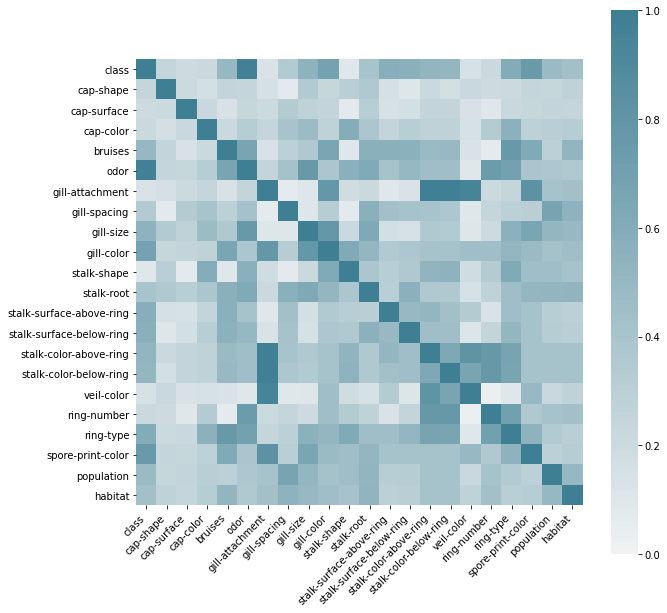

In [7]:
plt.figure(figsize = (10,10))
corr_mat
ax = sns.heatmap(
    corr_mat, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

To get a more meaningfull graph, let's sort the columns from the more "correlated" to "class", to the less :

<AxesSubplot:>

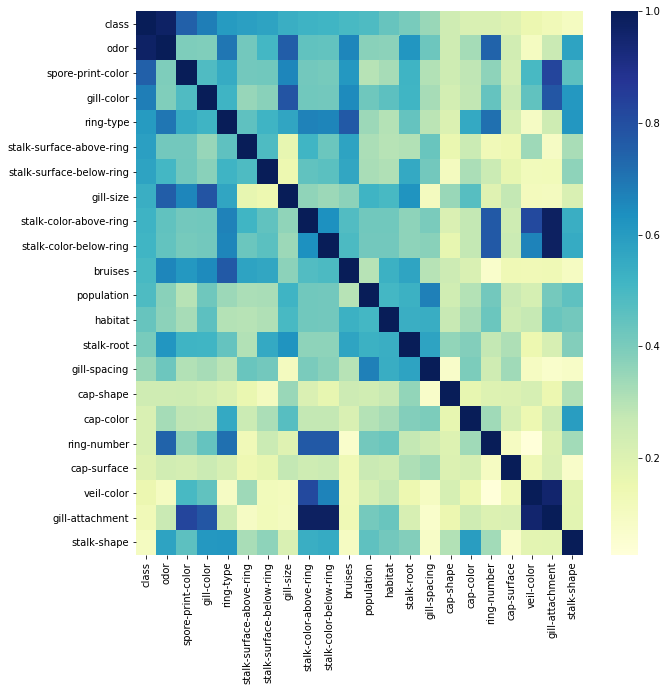

In [8]:
## EQUIVALENT PLOT WITH SEABORN :
import seaborn
plt.figure(figsize = (10,10))
new_index = np.argsort(-corr_mat["class"].values)
sorted_corr_mat = corr_mat.iloc[new_index,new_index]
seaborn.heatmap(sorted_corr_mat,cmap="YlGnBu")

The "odor" variable seems to match the "class" variable very tight, and the "stalk-shape","gill-attachment", "veil-color" seem to be not correlated at all. 

In [9]:
from tabulate import tabulate
print(tabulate(pd.crosstab(df_cat["class"],df_cat["odor"]), headers='keys', tablefmt='psql'))
print(tabulate(pd.crosstab(df_cat["class"],df_cat["stalk-shape"]), headers='keys', tablefmt='psql'))
print(tabulate(pd.crosstab(df_cat["class"],df_cat["gill-attachment"]), headers='keys', tablefmt='psql'))
print(tabulate(pd.crosstab(df_cat["class"],df_cat["veil-color"]), headers='keys', tablefmt='psql'))

+---------+-----+-----+------+-----+-----+------+-----+-----+-----+
| class   |   a |   c |    f |   l |   m |    n |   p |   s |   y |
|---------+-----+-----+------+-----+-----+------+-----+-----+-----|
| e       | 400 |   0 |    0 | 400 |   0 | 3408 |   0 |   0 |   0 |
| p       |   0 | 192 | 2160 |   0 |  36 |  120 | 256 | 576 | 576 |
+---------+-----+-----+------+-----+-----+------+-----+-----+-----+
+---------+------+------+
| class   |    e |    t |
|---------+------+------|
| e       | 1616 | 2592 |
| p       | 1900 | 2016 |
+---------+------+------+
+---------+-----+------+
| class   |   a |    f |
|---------+-----+------|
| e       | 192 | 4016 |
| p       |  18 | 3898 |
+---------+-----+------+
+---------+-----+-----+------+-----+
| class   |   n |   o |    w |   y |
|---------+-----+-----+------+-----|
| e       |  96 |  96 | 4016 |   0 |
| p       |   0 |   0 | 3908 |   8 |
+---------+-----+-----+------+-----+


Going back to our classification problem, Let's  transform these into numbers : 

In [10]:
from sklearn.preprocessing import LabelEncoder 
my_label_encoder = LabelEncoder()
df = df_cat.copy()
for col in df.columns :
    my_label_encoder.fit(df[col])
    df[col] = my_label_encoder.transform(df[col])
df.head(2)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1


Let's split the train and test sets : 

In [11]:
from sklearn.model_selection import train_test_split
# X = df.drop(["class",'odor'], axis=1) # dropping the most correlated
X = df.drop(["class","stalk-shape","gill-attachment", "veil-color" ], axis=1) # dropping the less correlated
# X = df.drop(["class"], axis=1)

y = df["class"]#np.array(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)

## 1. Logistic Regression : 
Different sets of parameters for our sklearn function : 

In [12]:
## Without any penalty and small datasets (n small): 
# lr_kwargs = {solver : "newton-cg" , dual : False, penalty : "none"}

## Without any penalty and big datasets (n >> 1):
lr_kwargs = {"solver" : "sag" ,  "penalty" : "none"} # or saga
lr_kwargs = {"solver" : "sag" , "penalty" : "none"}

# With penalty l2 and small datasets :
lr_kwargs = {"solver" : "liblinear" , "dual" : False, "penalty" : "l2"}
# and with big dim (p > n) :
lr_kwargs = {"solver" : "liblinear" , "dual" : True, "penalty" : "l2"} # recall : dual fit alpha in R^n 

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr_kwargs = {"solver" : "liblinear" , "dual" : False, "penalty" : "l2"}
my_logistic_reg = LogisticRegression(**lr_kwargs)
my_logistic_reg.fit(X_train, y_train)

## PREDICTION OF "PROBABILITY TO BE IN CLASS 1" (LOGISTIC RES)
lr_y_proba = my_logistic_reg.predict_proba(X_test)[:,1]
## CLASSIFICATION : 
lr_y_pred = my_logistic_reg.predict(X_test)
# y_pred = np.where(y_proba>=0.5, 1, 0)


Let's use some ROC metrics to check the classification results : 

0.9793630840142468


[]

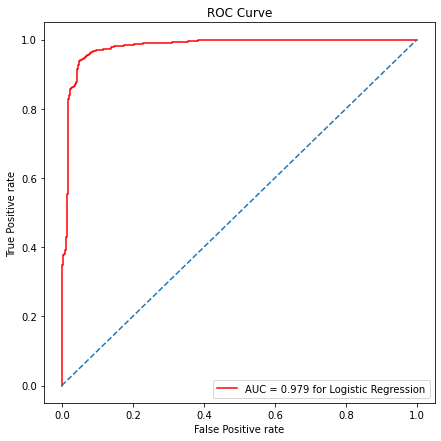

In [14]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve

lr_FPrate, lr_TPrate, lr_thresholds = roc_curve(y_test, lr_y_proba)
lr_roc_auc = auc(lr_FPrate, lr_TPrate)
print(lr_roc_auc)

plt.figure(figsize = (7,7))
plt.plot(lr_FPrate,lr_TPrate, color="red", label = "AUC = %0.3f for Logistic Regression"%lr_roc_auc)
## LEGEND AND AXIS : 
plt.legend(loc="lower right")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve")
plt.plot([0,1],[0,1], linestyle = '--') # random classif results
plt.plot()

## EQUIVALENT PLOT : 
# plot_roc_curve(my_logistic_reg, X_train, y_train)


Note that the following cell returned a warning message concerning the convergence in $l1$ when the data was complete (if I did not remove the non-correlated variables "stalk-shape","gill-attachment", and "veil-color") 

And with CV to fit the regularization parameter $C$ : 

In [15]:
lr_kwargs = {"solver" : "liblinear" , "dual" : False}#, "penalty" : "l1"}#["l1","l2"]}
param_grid = {"C": np.logspace(-3,3,7), "penalty" : ["l1","l2"]}

## GridSearchCV SYNTAXE : 
from sklearn.model_selection import GridSearchCV

CV_logistic_reg = GridSearchCV(LogisticRegression(**lr_kwargs),
                              param_grid = param_grid, cv = 5)
CV_logistic_reg.fit(X_train, y_train)
print(CV_logistic_reg.best_params_)

{'C': 1000.0, 'penalty': 'l1'}


The algorithm doesn't converge for $l1$ penalty : it takes half a minute to give a result, and warns that it had to increase the number of iteration, and convergence is not succeded. Thus, let's try just to fit the better $C$ with the $l2$ penalty only :

In [16]:
lr_kwargs = {"solver" : "liblinear" , "dual" : False, "penalty" : "l2"}#["l1","l2"]}
param_grid = {"C": np.logspace(-3,4,8)}

## GridSearchCV SYNTAXE : 
from sklearn.model_selection import GridSearchCV

CV_logistic_reg = GridSearchCV(LogisticRegression(**lr_kwargs),
                              param_grid = param_grid, cv = 5)
CV_logistic_reg.fit(X_train, y_train)
print(CV_logistic_reg.best_params_)

lr2_kwargs = lr_kwargs.copy()
lr2_kwargs.update(CV_logistic_reg.best_params_)
lr2_kwargs

{'C': 1000.0}


{'solver': 'liblinear', 'dual': False, 'penalty': 'l2', 'C': 1000.0}

Note that there is an implemented CV in sklearn for the logistic regression, that does exactly the same thing :
```python
## LogisticRegressionCV SYNTAXE (equivalent) : 
lr3_logistic_reg = LogisticRegressionCV(**lr_kwargs, Cs = param_grid["C"], cv = 5)
lr3_logistic_reg.fit(X_train, y_train)

my_logistic_reg_l2 = lr3_logistic_reg
```

So, let's launch the Logistic Regression with this best parameters (of $l2$ regularization)

0.9813458554611234


[]

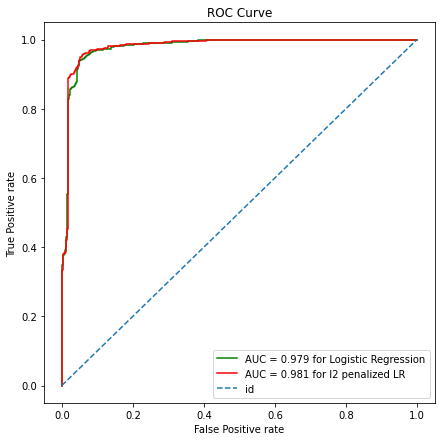

In [17]:
lr2_kwargs = {'solver': 'liblinear', 'dual': False, 'penalty': 'l2', 'C': 1000.0}
my_logistic_reg_l2 = LogisticRegression(**lr2_kwargs).fit(X_train, y_train)

## COMPARISON PLOT ROC logistic Reg and SVM, with l2 regul :
lr2_y_proba = my_logistic_reg_l2.predict_proba(X_test)[:,1]

lr2_FPrate, lr2_TPrate, lr2_thresholds = roc_curve(y_test, lr2_y_proba)
lr2_roc_auc = auc(lr2_FPrate, lr2_TPrate)
print(lr2_roc_auc)

plt.figure(figsize = (7,7))
plt.plot(lr_FPrate,lr_TPrate, color="green", label = "AUC = %0.3f for Logistic Regression"%lr_roc_auc)
plt.plot(lr2_FPrate,lr2_TPrate, color="red", label = "AUC = %0.3f for l2 penalized LR"%lr2_roc_auc)
plt.plot([0,1],[0,1], linestyle = '--', label = "id")
## LEGEND AND AXIS : 
plt.legend(loc="lower right")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve")
 # random classif results
plt.plot()

## EQUIVALENT PLOT : 
# plot_roc_curve(my_logistic_reg, X_train, y_train)


# TP Linear SVM
Let's do the same with SVM, regularize the solution and compare with the l2-regularized Logistic Regression :

In [18]:
from sklearn.svm import LinearSVC

svm_kwargs = {"dual" : False}
my_svm = LinearSVC(**svm_kwargs)
param_grid = {"C": np.logspace(-3,4,8)}

CV_svm = GridSearchCV(my_svm, param_grid, cv = 5)
CV_svm.fit(X_train, y_train) 

svm2_kwargs = svm_kwargs.copy()
svm2_kwargs.update(CV_svm.best_params_)
#svm2_kwargs |= CV_svm.best_params_ # in python 3.last :P 
svm2_kwargs

{'dual': False, 'C': 0.1}

Finally, let's compare the two regularized methods : 

[]

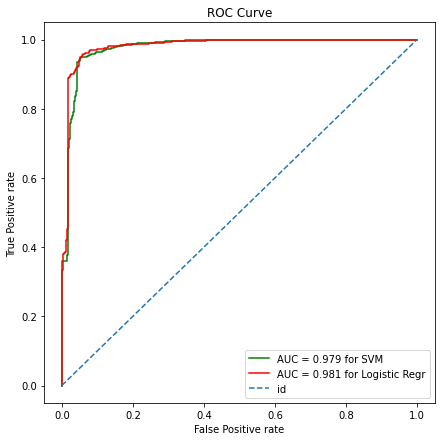

In [22]:
my_svm2 = LinearSVC(**svm2_kwargs).fit(X_train, y_train)

## COMPARISON PLOT ROC logistic Reg and SVM, with l2 regul :
svm_scores = my_svm2.decision_function(X_test)
svm2_FPrate, svm2_TPrate, svm2_thresholds = roc_curve(y_test, svm_scores)
svm2_roc_auc = auc(svm2_FPrate, svm2_TPrate)


plt.figure(figsize = (7,7))
plt.plot(svm2_FPrate,svm2_TPrate, color="green", label = "AUC = %0.3f for SVM "%lr_roc_auc)
plt.plot(lr2_FPrate,lr2_TPrate, color="red", label = "AUC = %0.3f for Logistic Regr"%lr2_roc_auc)
plt.plot([0,1],[0,1], linestyle = '--', label = "id") # random classif results
## LEGEND AND AXIS : 
plt.legend(loc="lower right")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve")
plt.plot()


In [ ]:

svm_score